# Grab Repository data      

In [39]:
from dotenv import load_dotenv
from helper.general import split_by_date, generate_value_in_buckets, truncate_to_same_length, aggregate_by_date, get_repository_paths
from helper.significance import check_normality_of_buckets, use_normality_results_for_significance_independent, use_normality_results_for_significance_independent
import logging
import pandas as pd
import ast
import os
import matplotlib.pyplot as plt

load_dotenv(override=True)

True

In [40]:
REPO_PATHS = os.getenv('STORAGE_DIRECTORIES')
repository_directories = ast.literal_eval(REPO_PATHS) if REPO_PATHS else []
INTRO_DATE = os.getenv('INTRO_DATE')
START_DATE = os.getenv('START_DATE')
END_DATE = os.getenv('END_DATE')
BUCKET_SIZE = int(os.getenv('BUCKET_SIZE'))
RESULTS_DIRECTORY = os.getenv("RESULTS_DIRECTORY")
storage_path = f'{RESULTS_DIRECTORY}/metric_calculation_{BUCKET_SIZE}/pull_requests_successful_per_{BUCKET_SIZE}_days.csv'

# Get only first-level subfolders in the repository directories
repositories = get_repository_paths(repository_directories)

print(repositories)

['/Users/annemariewittig/Master/repositoryanalysis/OSR/bootstrap', '/Users/annemariewittig/Master/repositoryanalysis/OSR/react-native', '/Users/annemariewittig/Master/repositoryanalysis/OSR/fastapi', '/Users/annemariewittig/Master/repositoryanalysis/OSR/vscode', '/Users/annemariewittig/Master/repositoryanalysis/OSR/gin', '/Users/annemariewittig/Master/repositoryanalysis/OSR/godot']


In [41]:
if INTRO_DATE == "":
    import json
    mapping_file = f"{repository_directories[0]}/mapping.json"
    # Check if the file exists
    if not os.path.exists(mapping_file):
        print(f"File not found: {mapping_file}. ")
    with open(mapping_file, 'r') as f:
        mapping = json.load(f)
    print(f"Using INTRO_DATE from mapping file: {INTRO_DATE}")

START_DATE = None
END_DATE = None


# Generate Commit Metrics per Repository

## Amount of Commits over time

In [ ]:
pr_result = []
for repository in repositories:
    if INTRO_DATE == "":
        person = repository.split('/')[-1]
        INTRO_DATE = mapping[person]['INTRO_DATE']
        START_DATE = mapping[person]['START_DATE']
        END_DATE = mapping[person]['END_DATE']
    pr_file = f"{repository}/pull_requests.csv"
    # Check if the file exists
    if not os.path.exists(pr_file) or os.stat(pr_file).st_size == 1:
        print(f"File not found or empty: {pr_file}. Skipping repository.")
        continue
    pr_df = pd.read_csv(pr_file)
    
    
    pr_df = pr_df[pr_df['time_until_merged'].notna()]
    
    pr_df = truncate_to_same_length(pr_df, INTRO_DATE, 'created_at', 'defined', START_DATE, END_DATE)

    # print(pr_df.head())
    # non_merged_nan = pr_df.loc[pr_df['state'] != 'MERGED', 'time_until_merged'].isna().all()
    # print(f"All non-MERGED states have time_until_merged as NaN: {non_merged_nan}")
    # print(pr_df['created_at'].max())
    
    pre_release, post_release = split_by_date(pr_df, INTRO_DATE, 'created_at')

    pre_release_buckets = generate_value_in_buckets(pre_release, 'created_at', 'count', 'sum', BUCKET_SIZE, 'pre-')
    post_release_buckets = generate_value_in_buckets(post_release, 'created_at', 'count', 'sum', BUCKET_SIZE, 'post-')

    # print(pre_release_buckets.head())
    release_buckets = pd.concat([pre_release_buckets, post_release_buckets], ignore_index=True)

    repo_name = repository.split('/')[-1]
    
    result_row = {'repository': repo_name}
    result_row.update(release_buckets.set_index('bucket')['count'].to_dict())  # Use 'count' instead of 'value'
    
    pr_result.append(result_row)

# Create the DataFrame
pr_result_df = pd.DataFrame(pr_result)


In [43]:
pr_result_df

,repository
0,bootstrap
1,react-native
2,fastapi
3,vscode
4,gin
5,godot


In [44]:
# Ensure the columns are in the correct order
def sort_buckets(df, prefix_one, prefix_two):
    order = ['repository']
    
    for prefix in [prefix_one, prefix_two]:
        counter = 0
        contained = True
        
        while contained:
            order.append(f'{prefix}{counter}')
            
            counter += 1
            if not f'{prefix}{counter}' in df:
                contained = False
        
    return order

# pr_result_df['pre-15'] = 0 # TODO check why missing

columns_order = sort_buckets(pr_result_df, 'pre-', 'post-')
pr_result_df = pr_result_df[columns_order]

KeyError: "['pre-0', 'post-0'] not in index"

In [ ]:
pr_result_df

,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,pre-8,...,post-1,post-2,post-3,post-4,post-5,post-6,post-7,post-8,post-9,post-10
0,bootstrap,0,0,0.0,0,0.0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,react-native,0,0,NaN,0,0.0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,fastapi,0,0,0.0,0,0.0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,vscode,0,0,0.0,0,0.0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,gin,0,0,0.0,0,0.0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
5,godot,0,0,0.0,0,NaN,0,0,0,NaN,...,0,0,0,0,0,0,0,0,0,0


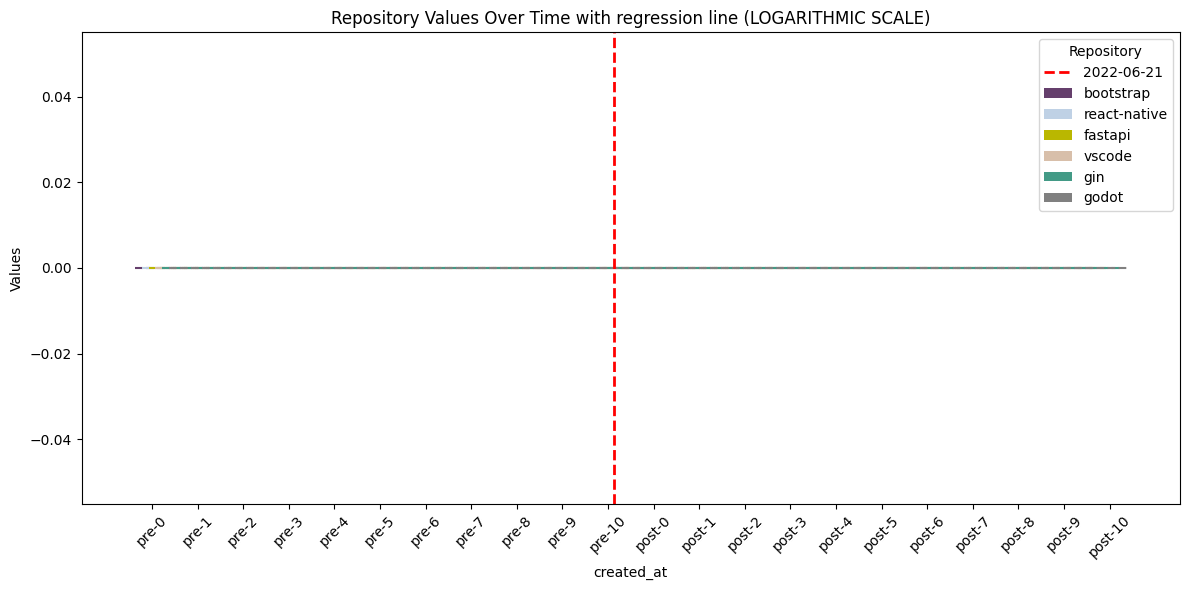

In [ ]:
import numpy as np
from scipy.stats import linregress

# Plotting the visualization as a grouped bar chart
plt.figure(figsize=(12, 6))

# Extract the date columns (x-axis labels)
date_columns = [col for col in pr_result_df.columns if col != 'repository']
colors = ["#653F6C", "#BFD1E5", "#BAB700", "#D8BFAA", "#439A86", "#808080", "#879970", "#896279"]
x = np.arange(len(date_columns))  # Numeric positions for the x-axis

# Bar width for grouped bars
bar_width = 0.15

# Loop through each repository and plot its bars
for i, repo in enumerate(pr_result_df['repository']):
    # Extract data for the current repository
    values = pr_result_df[pr_result_df['repository'] == repo].iloc[0, 1:].astype(float).fillna(0)
    # Adjust the x positions for this repository's bars
    plt.bar(x + i * bar_width, values.values, bar_width, label=repo, color=colors[i % len(colors)])
    
    # Add a regression line for the repository
    # Perform linear regression
    slope, intercept, _, _, _ = linregress(x, values.values)
    regression_line = slope * x + intercept
    plt.plot(x + i * bar_width, regression_line, color=colors[i % len(colors)], linestyle='--', label=f"_nolegend_")

# Dynamically find the largest 'pre-x' and 'post-0'
x_ticks = pr_result_df.columns[1:]  # Assuming these are the x-axis labels
pre_columns = [col for col in x_ticks if col.startswith('pre-')]
post_columns = [col for col in x_ticks if col.startswith('post-')]

if pre_columns and post_columns:
    largest_pre = max(pre_columns, key=lambda x: int(x.split('-')[1]))  # Find the largest 'pre-x'
    post_0 = 'post-0' if 'post-0' in post_columns else None  # Ensure 'post-0' exists

    if largest_pre and post_0:
        pre_index = list(x_ticks).index(largest_pre)
        post_0_index = list(x_ticks).index(post_0)
        midpoint = (pre_index + post_0_index) / 2
        plt.axvline(x=midpoint, color='red', linestyle='--', linewidth=2, label=INTRO_DATE)

# Set x-axis ticks and labels
plt.xticks(x + (len(pr_result_df['repository']) - 1) * bar_width / 2, date_columns, rotation=45)

# Add labels and title
plt.title('Repository Values Over Time with regression line (LOGARITHMIC SCALE)')
plt.xlabel('created_at')
plt.ylabel('Values')
plt.legend(title='Repository')
plt.tight_layout()
# plt.yscale('log')
plt.show()

# Significancetest 

In [ ]:
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Replace NaN values with 0 in the pr_result_df
pr_result_df = pr_result_df.fillna(0)

# Columns for pre and after buckets
pre_columns = [col for col in pr_result_df.columns if col.startswith("pre-")]
after_columns = [col for col in pr_result_df.columns if col.startswith("post-")]

normality_results = check_normality_of_buckets(pr_result_df, pre_columns, after_columns)

# Display the results
print(normality_results)

     repository  pre_p_value  after_p_value  pre_normal  after_normal
0     bootstrap          1.0            1.0        True          True
1  react-native          1.0            1.0        True          True
2       fastapi          1.0            1.0        True          True
3        vscode          1.0            1.0        True          True
4           gin          1.0            1.0        True          True
5         godot          1.0            1.0        True          True


/Users/annemariewittig/Master/repo-analysis/venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/Users/annemariewittig/Master/repo-analysis/venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/Users/annemariewittig/Master/repo-analysis/venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/Users/annemariewittig/Master/repo-analysis/venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, 

In [ ]:

# significance_results_df = use_normality_results_for_significance_independent(normality_results, pr_result_df, pre_columns, after_columns)

# # Display the results
# print(significance_results_df)

from helper.significance import calculate_cliffs_delta_with_confidence
significance_results_df = calculate_cliffs_delta_with_confidence(pr_result_df, pre_columns, after_columns)

# Display the results
print(significance_results_df)

     repository      test_used  effect_size  ci_lower  ci_upper
0     bootstrap  Cliff's Delta          0.0       0.0       0.0
1  react-native  Cliff's Delta          0.0       0.0       0.0
2       fastapi  Cliff's Delta          0.0       0.0       0.0
3        vscode  Cliff's Delta          0.0       0.0       0.0
4           gin  Cliff's Delta          0.0       0.0       0.0
5         godot  Cliff's Delta          0.0       0.0       0.0


In [ ]:
merged = pr_result_df.merge(significance_results_df, how='left')
merged.to_csv(storage_path)

merged 

,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,pre-8,...,post-5,post-6,post-7,post-8,post-9,post-10,test_used,effect_size,ci_lower,ci_upper
0,bootstrap,0,0,0.0,0,0.0,0,0,0,0.0,...,0,0,0,0,0,0,Cliff's Delta,0.0,0.0,0.0
1,react-native,0,0,0.0,0,0.0,0,0,0,0.0,...,0,0,0,0,0,0,Cliff's Delta,0.0,0.0,0.0
2,fastapi,0,0,0.0,0,0.0,0,0,0,0.0,...,0,0,0,0,0,0,Cliff's Delta,0.0,0.0,0.0
3,vscode,0,0,0.0,0,0.0,0,0,0,0.0,...,0,0,0,0,0,0,Cliff's Delta,0.0,0.0,0.0
4,gin,0,0,0.0,0,0.0,0,0,0,0.0,...,0,0,0,0,0,0,Cliff's Delta,0.0,0.0,0.0
5,godot,0,0,0.0,0,0.0,0,0,0,0.0,...,0,0,0,0,0,0,Cliff's Delta,0.0,0.0,0.0


In [ ]:
merged = pr_result_df.merge(significance_results_df, how='left')
merged.to_csv(storage_path)

merged 

,repository,pre-0,pre-1,pre-2,pre-3,pre-4,pre-5,pre-6,pre-7,pre-8,...,post-5,post-6,post-7,post-8,post-9,post-10,test_used,effect_size,ci_lower,ci_upper
0,bootstrap,0,0,0.0,0,0.0,0,0,0,0.0,...,0,0,0,0,0,0,Cliff's Delta,0.0,0.0,0.0
1,react-native,0,0,0.0,0,0.0,0,0,0,0.0,...,0,0,0,0,0,0,Cliff's Delta,0.0,0.0,0.0
2,fastapi,0,0,0.0,0,0.0,0,0,0,0.0,...,0,0,0,0,0,0,Cliff's Delta,0.0,0.0,0.0
3,vscode,0,0,0.0,0,0.0,0,0,0,0.0,...,0,0,0,0,0,0,Cliff's Delta,0.0,0.0,0.0
4,gin,0,0,0.0,0,0.0,0,0,0,0.0,...,0,0,0,0,0,0,Cliff's Delta,0.0,0.0,0.0
5,godot,0,0,0.0,0,0.0,0,0,0,0.0,...,0,0,0,0,0,0,Cliff's Delta,0.0,0.0,0.0


# Interpretation
- react-native: signficiantly more successful merges after introducing the tool with a very large effect
- vue: significantly less successful merges after introducing the tool with a very large effect